In [1]:
# %pip install yfinance
# %curl http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
# %tar -xzvf ta-lib-0.4.0-src.tar.gz
# %cd ta-lib
# %./configure --prefix=/usr
# %make
# %make install
# %pip install Ta-Lib

In [2]:
import numpy as np
import pandas as pd
import sys, os
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import yfinance as yf
import torchvision
import talib as ta
import statsmodels.tsa.stattools as ts
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


/home/jackb/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#read daily stock data series from yahoo finance
def get_data(name, start="2017-01-01", end="2020-01-01"):
    ticker = yf.Ticker(name)
    data=ticker.history(start=start,  end=end)
    return data.drop(['Dividends', 'Stock Splits'], axis=1, errors='ignore')

In [4]:
#Calculate technical analysis indicators into dataset
#Can be easily expanded
#Currently contains a small set of tech indicators
def calc_tech_ind(data):
    #overlap 
    data['upbd'], data['midbd'], data['lowbd'] = ta.BBANDS(data["Close"])
    data['dema'] = ta.DEMA(data["Close"], timeperiod=30)
    data['tema'] = ta.TEMA(data["Close"], timeperiod=30)
    data['ema'] = ta.EMA(data["Close"], timeperiod=30)
    data['wma'] = ta.WMA(data["Close"], timeperiod=30)
    data['sma'] = ta.SMA(data["Close"], timeperiod=30)
    data['sarext'] = ta.SAREXT(data["High"], data["Low"])
    
    #momentum
    data['adxr'] = ta.ADXR(data["High"], data["Low"], data["Close"], timeperiod=14)
    data['apo'] = ta.APO(data["Close"], fastperiod=12, slowperiod=26, matype=0)
    data['aroondown'], data['aroonup'] = ta.AROON(data["High"], data["Low"], timeperiod=14)
    data['cci'] = ta.CCI(data["High"], data["Low"], data["Close"], timeperiod=14)
    data['cmo'] = ta.CMO(data["Close"], timeperiod=14)
    data['macd'], data['macdsignal'], data['macdhist'] = ta.MACD(data["Close"], fastperiod=12, slowperiod=26, signalperiod=9)
    data['MFI'] = ta.MFI(data["High"], data["Low"], data["Close"], data['Volume'], timeperiod=14)
    data['mom'] = ta.MOM(data["Close"], timeperiod=10)
    data['plus_di'] = ta.PLUS_DI(data["High"], data["Low"], data["Close"], timeperiod=14)
    data['ppo'] = ta.PPO(data["Close"], fastperiod=12, slowperiod=26, matype=0)
    data['roc'] = ta.ROC(data["Close"], timeperiod=10)
    data['rocp'] = ta.ROCP(data["Close"], timeperiod=10)
    data['rsi'] = ta.RSI(data["Close"], timeperiod=14)
    data['slowk'], data['slowd'] = ta.STOCH(data["High"], data["Low"], data["Close"])
    data['fastk'], data['fastd'] = ta.STOCHF(data["High"], data["Low"], data["Close"])
    data['trix'] = ta.TRIX(data["Close"], timeperiod=30)
    data['ultosc'] = ta.ULTOSC(data["High"], data["Low"], data["Close"], timeperiod1=7, timeperiod2=14, timeperiod3=28)
    data['willr'] = ta.WILLR(data["High"], data["Low"], data["Close"], timeperiod=14)
    
    #volume
    data['ad'] = ta.AD(data["High"], data["Low"], data["Close"], data['Volume'])
    data['obv'] = ta.OBV(data["Close"], data['Volume'])
    
    #volitility
    data['atr'] = ta.ATR(data["High"], data["Low"], data["Close"], timeperiod=14)
    data['natr'] = ta.NATR(data["High"], data["Low"], data["Close"], timeperiod=14)
    
    #cycle
    data['HT_DCPERIOD'] = ta.HT_DCPERIOD(data["Close"])
    data['HT_DCPHASE'] = ta.HT_DCPHASE(data["Close"])
    data['inphase'], data['quadrature'] = ta.HT_PHASOR(data["Close"])
    
    
    return data

In [5]:
#download data of stocks given stock tickers and time frame
#data_list: an array of stock data with features
#high_correlation_list: id of stocks in data_list with high correlation with stock of interest
def get_data_set(stock_id, name_list, start="2017-01-01", end="2020-01-01"):
    data_list=[]
    for name in name_list:
        data_list.append(calc_tech_ind(get_data(name, start, end)).iloc[90:].fillna(0).values)
        
    #get number of original
    feature_count=data_list[0].shape[1]
    #calculate cointegration
    high_correlation_list=[]
    for j in range(len(data_list)):
        if stock_id != j:
            coint=ts.coint(data_list[stock_id][:, 3], data_list[j][:, 3])[1] 
            if coint <= 0.1:
                high_correlation_list.append(j)
            
    return data_list, high_correlation_list

In [6]:
#generate x, y, z, zp quadruples to sequence according to $timeStep and $gap
#x: historical data w/ technical analysis indicator
#y: closing price of t+1
#z:  difference between t+1 and t step's closing price
#zp:  difference between t+1 and t step's closing price, un-normalized
#hcl: high correlation list from get_data_set function
def toSequential(stock_id, name_list, timeStep=24, gap=12, start="2017-01-01", 
                 end="2020-01-01", use_external_list=False, external_list=[]):
    data_list, hcl=get_data_set(stock_id, name_list, start=start, end=end) 
    #For Validation and Testing, keep using the same HCL list. 
    if (use_external_list):
      hcl=external_list
      
    #append coint features to the end
    avg_features=np.zeros((data_list[stock_id].shape[0], data_list[stock_id].shape[1]-4))
    for k in hcl:
        feature=data_list[k][:, 4:]
        avg_features+=(feature-feature.mean(axis=0, keepdims=True))/(feature.std(axis=0, keepdims=True))
    #append to the end
    stkData=np.concatenate([data_list[stock_id], avg_features], axis=1)

    #closing: from id=0 to last
    closing=stkData[:, 3]
    #data from id=0 to second to last
    data=stkData[:-1]
    #calculating number of available sequential samples
    data_length=len(data)
    count=(data_length-timeStep)//gap+1
    stockSeq=[]
    labelSeq=[]
    diffSeq=[]
    realDiffSeq=[]
    for i in range(count):
        #segData dims: [timestep, feature count]
        segData=data[gap*i:gap*i+timeStep]
        segClosing=closing[gap*i:gap*i+timeStep+1]
        #segDiff=diff[gap*i:gap*i+timeStep]
        #normalization
        segDataNorm=np.nan_to_num((segData-segData.mean(axis=0, keepdims=True))/segData.std(axis=0, keepdims=True))
        segClosingNorm=(segClosing-segClosing.mean())/segClosing.std()
        #segDiff=(segDiff-segDiff.mean())/segDiff.std()
        
        stockSeq.append(segDataNorm)
        labelSeq.append(segClosingNorm[1:])
        diffSeq.append(segClosingNorm[1:]-segClosingNorm[:-1])
        realDiffSeq.append(segClosing[1:]-segClosing[:-1])
    stockSeq=np.array(stockSeq)
    labelSeq=np.array(labelSeq)
    diffSeq=np.array(diffSeq)
    realDiffSeq=np.array(realDiffSeq)
    return (stockSeq.astype('float32'), labelSeq.astype('float32'),
    diffSeq.astype('float32'), realDiffSeq.astype('float32'), hcl)

In [7]:
#input each step:  vector including [stock info, tech indicators]
#output each step: closing price t+1, price diff between t+1 and t
#full_list: output from get_data_set

class StockDataset(Dataset):
    def __init__(self, stock_id, name_list, transform=None, timestep=24, gap=12,
                 start="2017-01-01", end="2020-01-01",
                 use_external_list=False, external_list=[]):
        self.transform=transform
        self.id=stock_id
        
        
        #load data into cohort
        X, y, z, zp, hcl=toSequential(stock_id, name_list, timeStep=timestep, 
                                      gap=gap, start=start, end=end, 
                                      use_external_list=use_external_list, 
                                      external_list=external_list)

        self.X=X
        self.y=y  
        self.z=z  
        self.zp=zp
        self.high_correlation_list=hcl
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        """
        data returned in the format of 
        """
        if torch.is_tensor(idx):
            idx=idx.tolist()
        
        data=self.X[idx]
        label1=self.y[idx]
        label2=self.z[idx]
        label3=self.zp[idx]
        if self.transform:
            data=self.transform(data)
        return (data, label1, label2, label3)
    
    def getHighCorrelationList(self):
        return self.high_correlation_list

    def getDS(self):
        return self.X, self.y, self.z, self.zp

In [8]:
#define device
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In [9]:
#define GRU class
#init parameter: env_size for RL algorithm
class GRU(nn.Module):
    def __init__(self, env_size):
        super(GRU, self).__init__()
        self.rnn=nn.GRU(
            input_size=86,
            hidden_size=128,
            num_layers=1,
            batch_first=True
        )
        self.linear1=nn.Linear(256, env_size)
        self.linear2=nn.Linear(env_size, 1)
        self.num_layers=1
        
    def forward(self, x, state, device):
        batch_size,timestep, _=x.shape
        states, state=self.rnn(x, state)
        tamVec=tam(states, device)
        
        #concatVec: batch_size, time_step, hidden_size*2
        #i.e.       batch_size, 24       , 256        
        concatVec=torch.cat([states, tamVec],axis=2)
        envVec=self.linear1(torch.tanh(concatVec.reshape(batch_size*timestep, -1)))
        output=nn.Dropout(p=0.3)(envVec)
        output=nn.ReLU()(output)
        output=self.linear2(output)
        envVec=envVec.reshape(batch_size, timestep, -1)
        return (output.view(batch_size, -1), envVec), state
  
    def begin_state(self, device, batch_size=1): 
        # `nn.GRU` takes a tensor as hidden state
        return torch.zeros((
                    self.rnn.num_layers, batch_size, 128), device=device)

In [10]:
#temporal attention mechanism calculation
def tam(states, device):
    """
    Given $states: batch_size, time_step, hidden_size
    return $output states: batch_size, time_step, hidden_size*2
    """
    with torch.no_grad():
        b_size, t_step, h_size=states.shape
        # $time_step 0 
        vec_list=torch.tensor(np.zeros([b_size, 1, h_size]).astype('float32')).to(device)
        
        #i: time step from 1 to $time_step
        for i in range(1,states.shape[1]):
            batchedCum=torch.tensor(np.zeros([b_size, 1,1]).astype('float32')).to(device)
            batch_list=[]
            vec=torch.tensor(np.zeros([b_size, 1, h_size]).astype('float32')).to(device)
            for j in range(i):
                batched=torch.exp(torch.tanh(
                    torch.bmm(states[:,i:i+1,:], 
                              torch.transpose(states[:,j:j+1,:], 1, 2))))
                batch_list.append(batched)
                batchedCum+=batched
            for j in range(i):
                vec+=torch.bmm((batch_list[j]/batchedCum), states[:, j:j+1, :])
            vec_list=torch.cat([vec_list,vec], axis=1)
        #result=torch.cat([states, vec_list],axis=2)
    return vec_list
        

In [11]:
#RL Policy net modeled by parameters
class rlPolicy(nn.Module):
    def __init__(self, env_size, device):
        super(rlPolicy, self).__init__()
        self.rnn=GRU(env_size)
        self.rl=nn.RNN(
            input_size=env_size,
            hidden_size=128,
            num_layers=1,
            batch_first=True
        )
        self.linear=nn.Sequential(nn.BatchNorm1d(128), nn.ReLU(),nn.Dropout(0.3),
                                  nn.Linear(128, 32), nn.ReLU(),nn.Dropout(0.3),
                                  nn.Linear(32, 3))
        self.device=device

    #predP: predicition of t+1 closing prce
    #output: actions from -1 to 1 in shape (`batch_size`, `num_steps`)
    def forward(self, x, state):  
        batch_size,timestep, _=x.shape  
        (predP, envVec), state1=self.rnn(x, state[0], self.device)
        output, state2=self.rl(envVec, state[1])
        output=self.linear(output.reshape(batch_size*timestep, -1))
        #predP: price prediction of t+1, output: (batch, timestep, 128) of actions
        return predP, output.view(batch_size,timestep, -1)
    
    def begin_state(self, device, batch_size=1): 
        # `nn.GRU` takes a tensor as hidden state
        return [self.rnn.begin_state(device, batch_size),
                self.rnn.begin_state(device, batch_size)]

In [12]:
#Calculate Utility based on policy Output
#z: z from dataset
#c: transaction cost
def calcUtility(policyOutput, z, c=0.001):
  with torch.no_grad():
    discretize=policyOutput.detach()
    batch, step, _=policyOutput.shape
    #discretize: batch, step, 3
    discretize=discretize.reshape(batch*step,-1)
    discretize=torch.argmax(discretize, dim=1, keepdim=True) #{0, 1, 2}
    discretize=discretize.reshape(batch, step)
    preAction=torch.cat([discretize[:,0:1], discretize[:, :-1]], dim=1)
    #net income R
    R=z*(discretize-1)-c*((discretize-preAction)!=0)
    U=torch.cumsum(R, dim=1)
    return U, preAction

In [13]:
#Prevent exploding gradient
def grad_clipping(net, theta): 
    """Clip the gradient."""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [14]:
#model weight initialization
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.normal_(0.0,0.01)

In [15]:
#Loss function defined by paper
def lossFunc(predP, y, policyOutput, z, device):
    #MSE
    term1=nn.MSELoss()(predP, y)
    #RL
    U, preAction=calcUtility(policyOutput, z)
    U_detach=U.detach()
    sfPolicyOutput=nn.Softmax(dim=2)(policyOutput)
    actionProb=torch.squeeze(torch.gather(sfPolicyOutput, 2, torch.unsqueeze(preAction, -1)))
    term2=-torch.log(actionProb)*U_detach
    return term2.mean()+term1

In [16]:
#greedy loss function
def lossFunc2(predP, y, policyOutput, z, device):
    #MSE
    term1=nn.MSELoss()(predP, y)
    #RL
    greedyAction=(z>=0.01)*2
    one_hot=torch.nn.functional.one_hot(greedyAction)
    U, preAction=calcUtility(policyOutput, z)
    U_detach=U.detach()
    sfPolicyOutput=nn.Softmax(dim=2)(policyOutput)
    actionProb=torch.squeeze(torch.gather(sfPolicyOutput, 2, torch.unsqueeze(preAction, -1)))
    term2=-torch.log(actionProb)*U_detach
    term3=nn.CrossEntropyLoss()(policyOutput.view(-1, 3), greedyAction.view(-1))
    return 0.5*term3+term2.mean()+term1

In [17]:
#trainer for epoch
def train_epoch(net, train_iter, device, optimizer, lossfn):
    loss_data=[]
    with torch.autograd.set_detect_anomaly(True):
        for X, y, z, _ in train_iter:
            #reset state for each batch
            state=net.begin_state(batch_size=X.shape[0], device=device)
        
            #move to device
            X, y, z=X.to(device), y.to(device), z.to(device)
            predP, output=net(X, state)
            loss=lossfn(predP, y, output,z, device)
            optimizer.zero_grad()
            loss.backward()
            grad_clipping(net, 1)
            optimizer.step()
            loss_data.append(loss.item())
    return np.array(loss_data).mean(), loss_data

In [18]:
#Testing on trained model
def prediction(net, eval_iter, device, lossfn):
    net.eval()
    loss_list=[]
    U_list=[]
    with torch.no_grad():
        for X, y, z, _ in eval_iter:
            X, y, z = X.to(device), y.to(device), z.to(device)
            state=net.begin_state(batch_size=X.shape[0], device=device)
            predP, output=net(X, state)
            loss=lossfn(predP, y, output, z, device)
            U, _=calcUtility(output, z)
            loss_list.append(loss.cpu().numpy())
            U_list.append(U[:, -1].mean().cpu().numpy())
    return np.array(loss_list).mean(), np.array(U_list).mean()

In [19]:
#Trainer 
#Incoporated learning rate scheduler
#Avg training loss & Avg validation Utility gain is recorded on epoch basis
#Loss and Utility by epoch are plotted at the end of training
def train(net, train_iter, eval_iter, optimizer, device, num_epoch, name, lossfn=lossFunc):
    loss_data=[]
    U_data=[]
    net.apply(init_weights)
    net.to(device)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.95, last_epoch=-1)
    
    for epoch in range(num_epoch):
        net.train()
        lossEpoch, lossEpoch_list=train_epoch(net, train_iter, device, optimizer, lossfn=lossfn)   
        loss_v, U_v=prediction(net, eval_iter, device, lossfn=lossfn)
        loss_data.append(lossEpoch)  
        U_data.append(U_v)
        print(f'Epoch {epoch}, training loss: {lossEpoch:.2f}, val utility: {U_v:.2f}')
        torch.save(net.state_dict(), os.path.join('./model_weights', f'{name}-epoch-{epoch}.pth'))
        scheduler.step()
    
    #plot loss & Utility
    fig, ax_left = plt.subplots(figsize=(10,4))
    ax_right = ax_left.twinx()
    ax_left.plot(loss_data, label = "Loss", color='blue')
    ax_right.plot(U_data, label = "Utility", color='red')
    ax_left.set_xlabel('Time Step')
    ax_right.set_ylabel('Loss y axis')
    ax_right.set_ylabel('Utility y axis')
    ax_left.set_title('Loss and Utility')
    ax_left.legend()
    ax_right.legend()
    return loss_data

In [20]:
#Generation of training, validation, and testing dataset
def DataIterGen(stock_id, name_list, demo=False):
    """
    test_id_list: id of subjects for testing
    val_id_list: id of subjects for validation
    other subjects for training
    full_list=get_data_set(name_list), preprocessed
    demo: when demo mode is True, only test_iter is returned, with data from
    first entry of test_id_list (single stock)
    """
    trainDS=StockDataset(stock_id, name_list, start="2013-01-01", end="2017-10-01")
    #get high correlation list for validation and testing
    hcl=trainDS.getHighCorrelationList()
    if demo:
      test_iter=DataLoader(StockDataset(stock_id, name_list, timestep=24, gap=1, 
                                        start="2018-01-01", end="2019-01-01",
                                        use_external_list=True, external_list=hcl), 
                           shuffle=False, batch_size=64, num_workers=0)
      
      #get abs change in stock closing price:
      data=get_data(name_list[stock_id], start="2018-01-01", end="2019-01-01")
      delta=data.iloc[-1]['Close']-data.iloc[91]['Close']
      print(f'Demo Stock ticker: {name_list[stock_id]}, change in closing price during testing period: ${delta:.2f}')
      return test_iter
    else:
      test_iter=DataLoader(StockDataset(stock_id, name_list, 
                                        start="2018-01-01", end="2019-01-01",
                                        use_external_list=True, external_list=hcl),
                            batch_size=32, num_workers=0)
      val_iter=DataLoader(StockDataset(stock_id, name_list,
                                       start="2017-07-01", end="2018-04-01",
                                       use_external_list=True, external_list=hcl),
                           batch_size=32, num_workers=0)
      train_iter=DataLoader(trainDS, shuffle=True, batch_size=32, num_workers=0)
      print(f'Stock ticker: {name_list[stock_id]}')
      return train_iter, val_iter, test_iter

In [21]:
def test(net, test_iter, device, epoch, name):
    net.eval()
    net.load_state_dict(torch.load(os.path.join('./model_weights', f'{name}-epoch-{epoch}.pth')))
    device=try_gpu()
    net.to(device)
    U_list=[]
    with torch.no_grad():
        for X, _, _, zp in test_iter:
            X, zp = X.to(device),  zp.to(device)
            state=net.begin_state(batch_size=X.shape[0], device=device)
            predP, output=net(X, state)
            U, _=calcUtility(output, zp)
            U_list.append(U[:, -1].mean().cpu().numpy())
    return np.array(U_list).mean()

In [22]:
def demo(net, demo_iter, device, epoch, name):
    net.eval()
    net.load_state_dict(torch.load(os.path.join('./model_weights', f'{name}-epoch-{epoch}.pth')))
    device=try_gpu()
    net.to(device)
    reward=np.array([])
    with torch.no_grad():
        for X, _, _, zp in demo_iter:
          X, zp = X.to(device),  zp.to(device)
          state=net.begin_state(batch_size=X.shape[0], device=device)
          predP, output=net(X, state)
          batch, step, _=output.shape
          #discretize: batch, step, 3
          discretize=output.reshape(batch*step,-1)
          discretize=torch.argmax(discretize, dim=1, keepdim=True)-1 #{-1, 0, 1}
          discretizedAction=discretize.reshape(batch, step)
          batchReward=discretizedAction*zp
          reward=np.concatenate((reward,batchReward[:,-1].reshape(-1).cpu().numpy()))
        result = [sum(reward[ : i + 1]) for i in range(len(reward))] 
    fig, ax_left = plt.subplots(figsize=(20,3))
    ax_left.plot(result, label = "Stock Gain", color='blue')
    ax_left.set_xlabel('Time Step')
    ax_left.set_ylabel('Cumulative Gain')
    ax_left.set_title('Demonstration of Algorithm')
    ax_left.legend()
    return 

In [23]:
#Stock List
stockList1=['COO','COF','ABBV','CCL','AMD','GOOG','ABMD','ABT','ACN','ADBE',
            'AES','NVDA','AIG','ALL', 'AMG','AMZN','APA','AAPL', 'AXP', 
            'JPM', 'HD',
            'BA','BBY','CAT','GE','CSCO',
            'EA','EQR','FCX','FE','HST',
            'IBM','INTC','JCI','MMM','MO','ORCL','PPL','T','EXPD','VMC','VNO']


In [24]:
train_iter, val_iter, test_iter=DataIterGen(0, stockList1)

Stock ticker: COO


mkdir: cannot create directory ‘model_weights’: File exists
Epoch 0, training loss: 1.23, val utility: -0.15
Epoch 1, training loss: 0.73, val utility: -0.50
Epoch 2, training loss: 0.93, val utility: -0.76
Epoch 3, training loss: 0.93, val utility: -0.86
Epoch 4, training loss: 0.99, val utility: -0.78
Epoch 5, training loss: 0.92, val utility: -0.77
Epoch 6, training loss: 0.82, val utility: -0.60
Epoch 7, training loss: 1.14, val utility: -0.51
Epoch 8, training loss: 0.72, val utility: -0.56
Epoch 9, training loss: 0.77, val utility: -0.56
Epoch 10, training loss: 0.78, val utility: -0.57
Epoch 11, training loss: 0.41, val utility: -0.57
Epoch 12, training loss: 0.93, val utility: -0.50
Epoch 13, training loss: 0.56, val utility: -0.53
Epoch 14, training loss: 0.82, val utility: -0.56
Epoch 15, training loss: 0.79, val utility: -0.51
Epoch 16, training loss: 0.78, val utility: -0.28
Epoch 17, training loss: 0.74, val utility: -0.40
Epoch 18, training loss: 0.78, val utility: -0.44


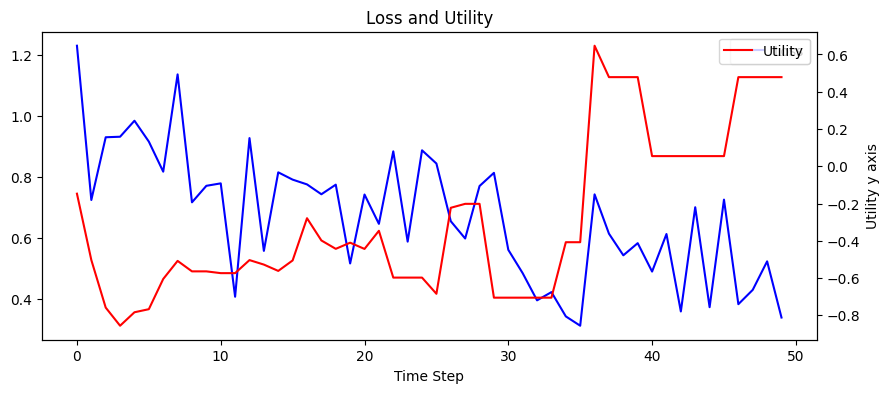

In [25]:
#Training in action
%mkdir model_weights
device=try_gpu()
net=rlPolicy(128, device)
optim1 = optim.Adam(net.parameters(), lr=0.0001, weight_decay=0.01)
loss=train(net, train_iter, val_iter, optim1, device, 50, 'DLRL')

On average, every 24 days the algorithm yields:0.9440706968307495
Demo Stock ticker: COO, change in closing price during testing period: $4.84


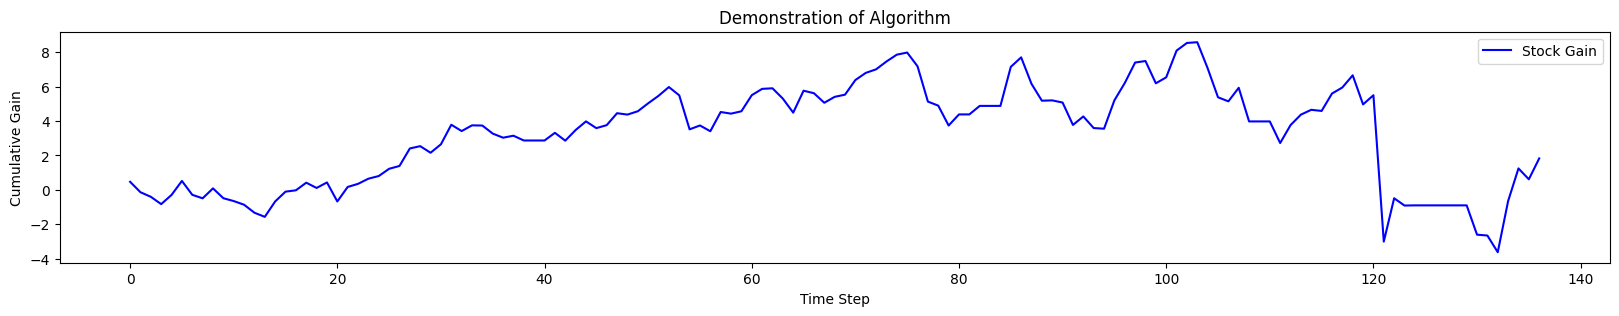

In [26]:
avgReturn=test(net, test_iter, device, 25, 'DLRL')
print(f'On average, every 24 days the algorithm yields:{avgReturn}' )
demo_iter=DataIterGen(0, stockList1, demo=True)
demo(net, demo_iter , device, 25, 'DLRL')

In [27]:
train_iter, val_iter, test_iter=DataIterGen(3, stockList1)

Stock ticker: CCL


Epoch 0, training loss: 1.83, val utility: 2.17
Epoch 1, training loss: 1.64, val utility: 1.55
Epoch 2, training loss: 1.63, val utility: 2.14
Epoch 3, training loss: 1.89, val utility: 1.97
Epoch 4, training loss: 1.63, val utility: 2.31
Epoch 5, training loss: 1.79, val utility: 2.67
Epoch 6, training loss: 1.85, val utility: 2.79
Epoch 7, training loss: 1.82, val utility: 3.49
Epoch 8, training loss: 1.98, val utility: 3.54
Epoch 9, training loss: 1.79, val utility: 3.12
Epoch 10, training loss: 2.02, val utility: 3.15
Epoch 11, training loss: 2.05, val utility: 2.81
Epoch 12, training loss: 1.91, val utility: 2.99
Epoch 13, training loss: 1.81, val utility: 3.00
Epoch 14, training loss: 1.96, val utility: 2.56
Epoch 15, training loss: 1.90, val utility: 2.56
Epoch 16, training loss: 2.10, val utility: 1.57
Epoch 17, training loss: 1.82, val utility: 1.28
Epoch 18, training loss: 2.08, val utility: 1.27
Epoch 19, training loss: 1.81, val utility: 1.47
Epoch 20, training loss: 1.88,

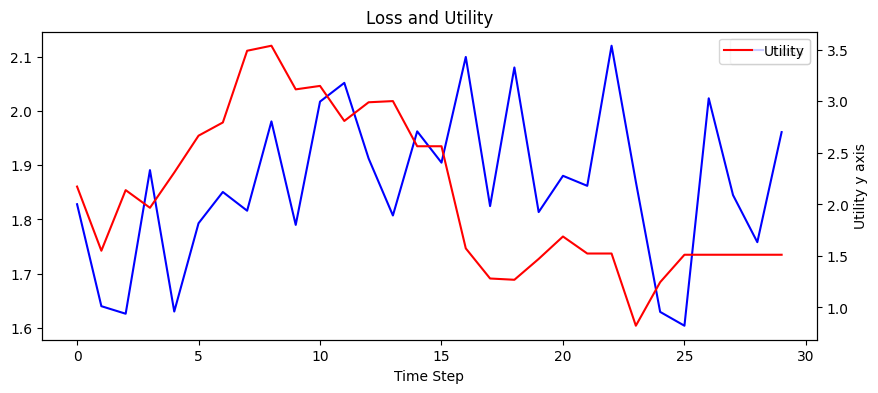

In [28]:
optim1 = optim.Adam(net.parameters(), lr=0.0001, weight_decay=0.01)
loss=train(net, train_iter, val_iter, optim1, device, 30, 'DLRL', lossfn=lossFunc2)

On average, every 24 days the algorithm yields:0.1255338490009308
Demo Stock ticker: CCL, change in closing price during testing period: $-13.26


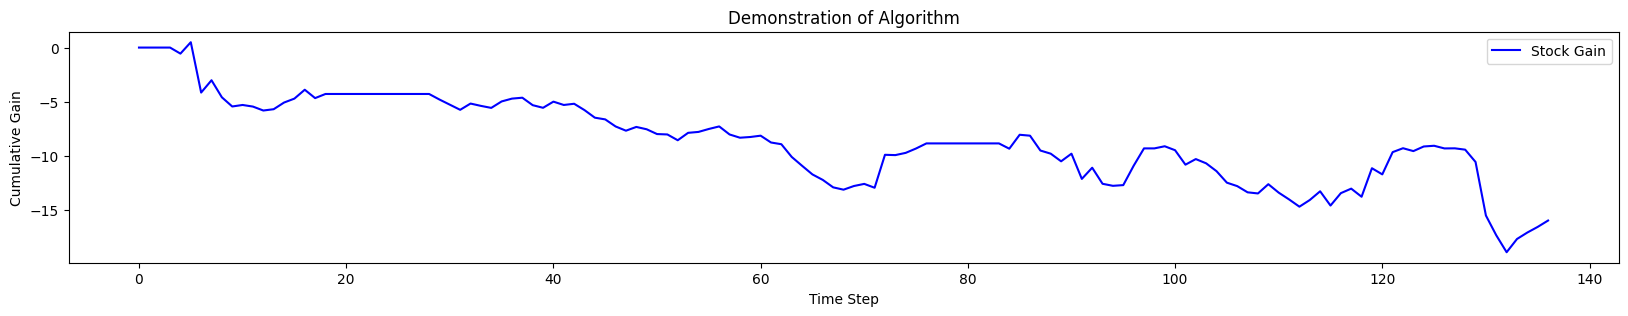

In [29]:
avgReturn=test(net, test_iter, device, 4, 'DLRL')
print(f'On average, every 24 days the algorithm yields:{avgReturn}' )
demo_iter=DataIterGen(3, stockList1, demo=True)
demo(net, demo_iter , device, 4, 'DLRL')

In [30]:
train_iter, val_iter, test_iter=DataIterGen(2, stockList1)

Stock ticker: ABBV


Epoch 0, training loss: 2.03, val utility: -0.37
Epoch 1, training loss: 1.99, val utility: -0.54
Epoch 2, training loss: 1.89, val utility: -0.44
Epoch 3, training loss: 1.98, val utility: -0.44
Epoch 4, training loss: 1.86, val utility: -0.47
Epoch 5, training loss: 1.78, val utility: -0.47
Epoch 6, training loss: 1.57, val utility: -0.50
Epoch 7, training loss: 1.77, val utility: -0.50
Epoch 8, training loss: 1.92, val utility: -0.50
Epoch 9, training loss: 1.85, val utility: -0.56
Epoch 10, training loss: 2.02, val utility: -0.93
Epoch 11, training loss: 2.03, val utility: -0.93
Epoch 12, training loss: 1.78, val utility: -0.93
Epoch 13, training loss: 1.82, val utility: -0.93
Epoch 14, training loss: 1.77, val utility: -0.93
Epoch 15, training loss: 1.81, val utility: -0.98
Epoch 16, training loss: 1.88, val utility: -0.98
Epoch 17, training loss: 2.02, val utility: -0.94
Epoch 18, training loss: 1.67, val utility: -0.94
Epoch 19, training loss: 1.59, val utility: -0.98
Epoch 20, 

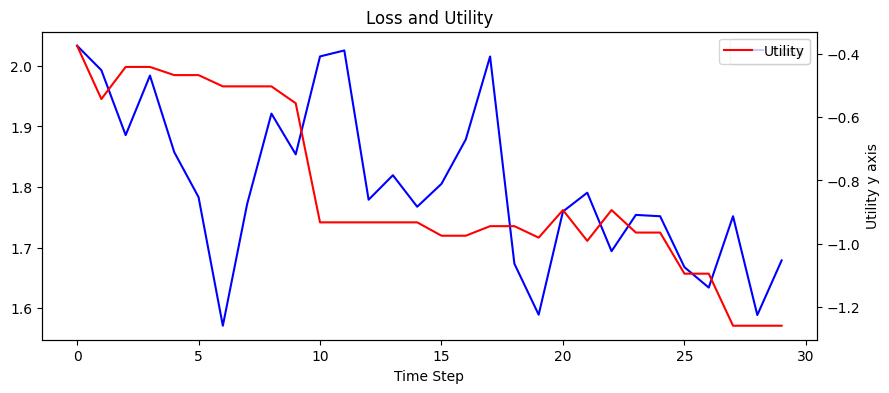

In [31]:
loss=train(net, train_iter, val_iter, optim1, device, 30, 'DLRL', lossfn=lossFunc2)

In [32]:
avgReturn=test(net, test_iter, device, 17, 'DLRL')
print(f'On average, every 24 days the algorithm yields:{avgReturn}' )

On average, every 24 days the algorithm yields:0.9875985383987427


In [33]:
demo_iter=DataIterGen(2, stockList1, demo=True)

Demo Stock ticker: ABBV, change in closing price during testing period: $-8.87


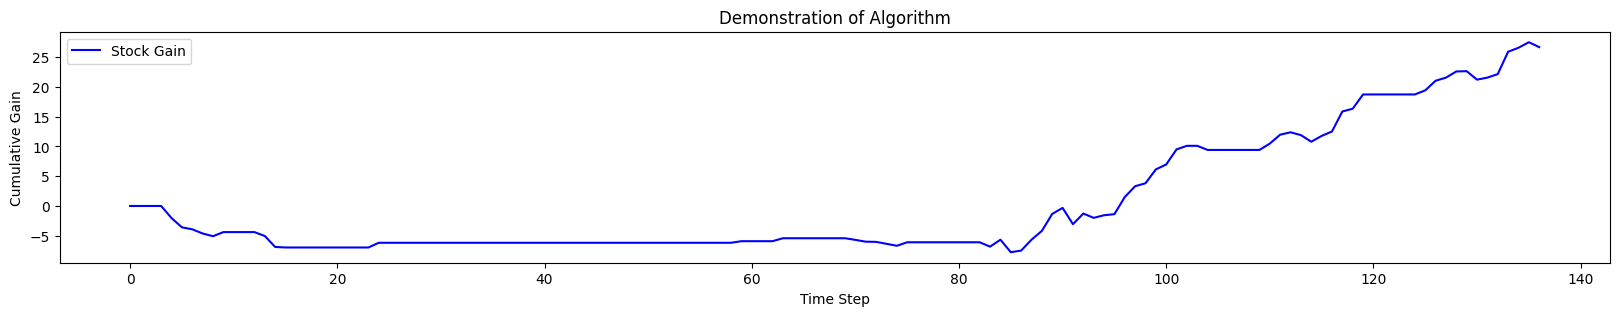

In [34]:
demo(net, demo_iter , device, 17, 'DLRL')

In [35]:
#Training in action
train_iter, val_iter, test_iter=DataIterGen(5, stockList1)

Stock ticker: GOOG


Epoch 0, training loss: 1.69, val utility: -0.57
Epoch 1, training loss: 1.92, val utility: -0.57
Epoch 2, training loss: 1.76, val utility: -0.57
Epoch 3, training loss: 1.79, val utility: -0.57
Epoch 4, training loss: 1.78, val utility: -0.52
Epoch 5, training loss: 1.64, val utility: -0.52
Epoch 6, training loss: 1.77, val utility: -0.52
Epoch 7, training loss: 1.95, val utility: -0.52
Epoch 8, training loss: 1.62, val utility: -0.52
Epoch 9, training loss: 1.95, val utility: -0.52
Epoch 10, training loss: 1.76, val utility: -0.52
Epoch 11, training loss: 1.81, val utility: -0.52
Epoch 12, training loss: 1.59, val utility: -0.52
Epoch 13, training loss: 1.72, val utility: -0.52
Epoch 14, training loss: 1.75, val utility: -0.52
Epoch 15, training loss: 1.74, val utility: -0.50
Epoch 16, training loss: 1.78, val utility: -0.50
Epoch 17, training loss: 1.70, val utility: -0.50
Epoch 18, training loss: 1.78, val utility: -0.50
Epoch 19, training loss: 1.83, val utility: -0.50
Epoch 20, 

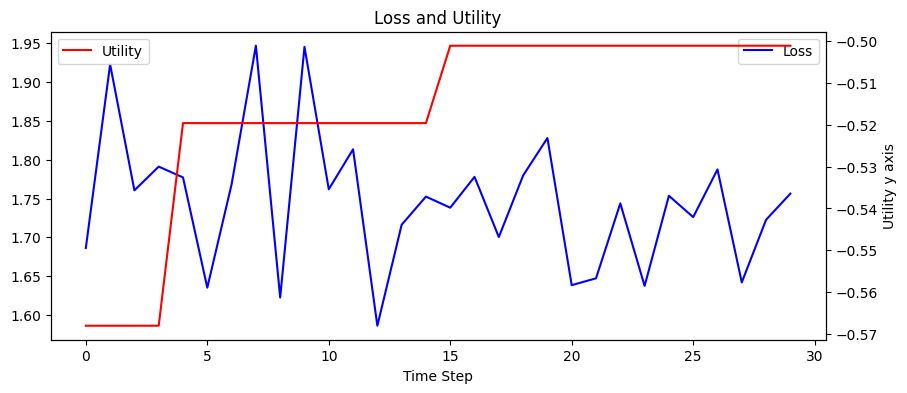

In [36]:
loss=train(net, train_iter, val_iter, optim1, device, 30, 'DLRL', lossfn=lossFunc2)

In [37]:
avgReturn=test(net, test_iter, device, 12, 'DLRL')
print(f'On average, every 24 days the algorithm yields:{avgReturn}' )

On average, every 24 days the algorithm yields:0.26898467540740967


Demo Stock ticker: GOOG, change in closing price during testing period: $-3.23


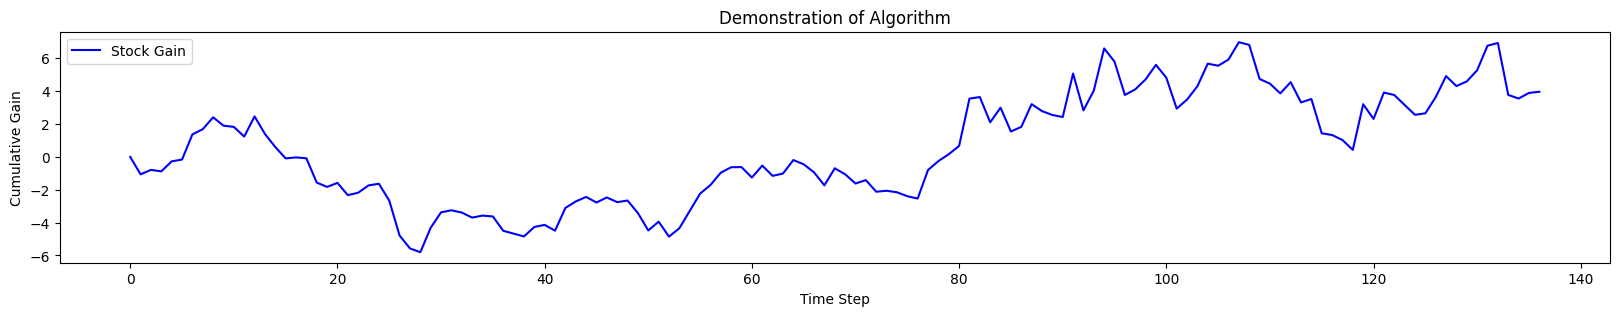

In [38]:
demo_iter=DataIterGen(5, stockList1, demo=True)
demo(net, demo_iter , device, 12, 'DLRL')